In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t, f

In [5]:
class SLR():
    """
    Construct a simple linear regression model and conduct required estimations and hypothesis test.
    """
    def __init__(self, src: str, predictor: str, response: str) -> None:
        super(SLR, self).__init__
        self.src = src
        self.predictor = predictor
        self.response = response


    def load_data(self):
        df = pd.read_csv(self.src)
        self.X = np.array(df[self.predictor])
        self.Y = np.array(df[self.response])
        pass
    
    def fit(self):        
        self.x_bar = np.mean(self.X)
        self.y_bar = np.mean(self.Y)

        self.SS_xx = sum((x - self.x_bar) ** 2 for x in self.X)
        self.SS_yy = sum((y - self.y_bar) ** 2 for y in self.Y)
        self.SS_xy = sum((x - self.x_bar) * (y - self.y_bar) for (x,y) in zip(self.X, self.Y))
        # print(self.SS_xx); print(self.SS_yy); print(self.SS_xy)
 
        self.b1_hat = self.SS_xy / self.SS_xx
        self.b0_hat = self.y_bar - self.b1_hat * self.x_bar
        pass    

    def compute_standard_error(self):
        self.n = len(self.Y)
        self.e = np.array([y - (self.b0_hat + self.b1_hat * x) for (x,y) in zip(self.X, self.Y)])
        self.SS_E = sum((y - (self.b0_hat + self.b1_hat * x)) ** 2 for (x,y) in zip(self.X, self.Y))
        self.se = self.SS_E / (self.n - 2)
        self.se_b1_hat = (self.se / self.SS_xx) ** (1/2)
        self.se_b0_hat = (self.se * ( 1 / self.n + self.x_bar ** 2 / self.SS_xx)) ** (1/2)
        # print(self.se); print(self.se_b1_hat); print(self.se_b0_hat)
        pass

    def ANOVA(self):
        self.SS_R = sum(((self.b0_hat + self.b1_hat * x) - self.y_bar) ** 2 for x in self.X)
        self.SS_T = self.SS_R + self.SS_E
        self.Rsquare = self.SS_R / self.SS_T
        pass

    def hypothesis_test(self, level: float = 0.95):
        self.compute_standard_error()

        self.t_b1_hat = (self.b1_hat - 0) / self.se_b1_hat
        self.t_b0_hat = (self.b0_hat - 0) / self.se_b0_hat
        
        self.df = self.n - 2
        self.t_c = t.ppf(level, df = self.df)
        self.pval_b1 = t.sf(self.t_b1_hat, self.df) * 2
        self.pval_b0 = t.sf(self.t_b0_hat, self.df) * 2

        self.r = self.SS_xy / (self.SS_xx * self.SS_yy) ** (1/2)
        self.t_r = self.r * (self.df / (1 - self.r ** 2)) * (1/2)
        self.pval_r = t.sf(self.t_r, self.df) * 2

        self.ANOVA()
        self.F = (self.SS_R / 1) / (self.SS_E / self.df)
        self.pval_F = t.sf(self.F, self.df) * 2
        pass

    def visualize(self):
        self.func = lambda x: self.b0_hat + self.b1_hat * x
        fig , axs = plt.subplots(1, 2, figsize = (10,5), dpi = 100)
        axs[0].scatter(self.X, self.Y, s = 20)
        axs[0].plot(self.X, self.func(self.X), color = 'red', linestyle = 'dashed')
        axs[0].set_xlabel(self.predictor)
        axs[0].set_ylabel(self.response)
        axs[0].set_title(f"{self.response} vs. {self.predictor}")
        axs[0].grid(True)

        axs[1].scatter(self.Y, self.e / self.se, s = 20)
        axs[1].axhline(y = 0, color = 'red')
        axs[1].set_xlabel(self.response)
        axs[1].set_ylabel("Standardized Residual")
        axs[1].set_title(f"Residual Analysis")
        axs[1].grid(True)

        fig.tight_layout()
        pass

    def summary(self):
        self.load_data()
        self.fit()
        self.compute_standard_error()
        self.ANOVA()
        self.hypothesis_test()

        print(f"\t  Min \t Q1 \t Median \t Q3 \tMax")
        print(f"Residuals: {round(np.min(self.e), 4)} \t {round(np.quantile(self.e, .25), 4)} \t {round(np.median(self.e), 4)} \t {round(np.quantile(self.e, .75), 4)} \t {round(np.max(self.e), 4)}")
        print("\n\t  Coefficient \t Std. Error \t t-Statistic \t |t|>t_c? \t Pr(>|t|)")
        print(f"Intercept: {round(self.b0_hat, 4)} \t {round(self.se_b0_hat, 4)} \t {round(self.t_b0_hat, 4)} \t {round(self.t_b0_hat - self.t_c)} \t {self.pval_b0}")
        print(f"{self.predictor}: {round(self.b1_hat, 4)} \t {round(self.se_b1_hat, 4)} \t {round(self.t_b1_hat, 4)} \t {round(self.t_b1_hat - self.t_c)} \t {self.pval_b1}")
        print(f"\nResidual Std. Error: {round(self.se ** (1/2), 4)} on {self.df} DF")
        print(f"R-square: {round(self.Rsquare, 4)}")
        print(f"Pearson correlation coef.: {self.r}, p-value: {self.pval_r}")
        print(f"F-statistic: {round(self.F, 4)} on 1 predictor and {self.df} DF, p-value: {self.pval_F}")

        self.visualize()
        
        pass




	  Min 	 Q1 	 Median 	 Q3 	Max
Residuals: -282.1706 	 -24.8289 	 1.8074 	 29.7912 	 188.792

	  Coefficient 	 Std. Error 	 t-Statistic 	 |t|>t_c? 	 Pr(>|t|)
Intercept: 1.3587 	 13.7682 	 0.0987 	 -2 	 0.9216570019132004
Market_Val: 1.4083 	 0.0369 	 38.1322 	 36 	 2.1120509853669011e-50

Residual Std. Error: 68.7566 on 74 DF
R-square: 0.9516
Pearson correlation coef.: 0.9754858492702432, p-value: 3.7390046863650894e-145
F-statistic: 1454.0619 on 1 predictor and 74 DF, p-value: 1.2466417199930903e-166


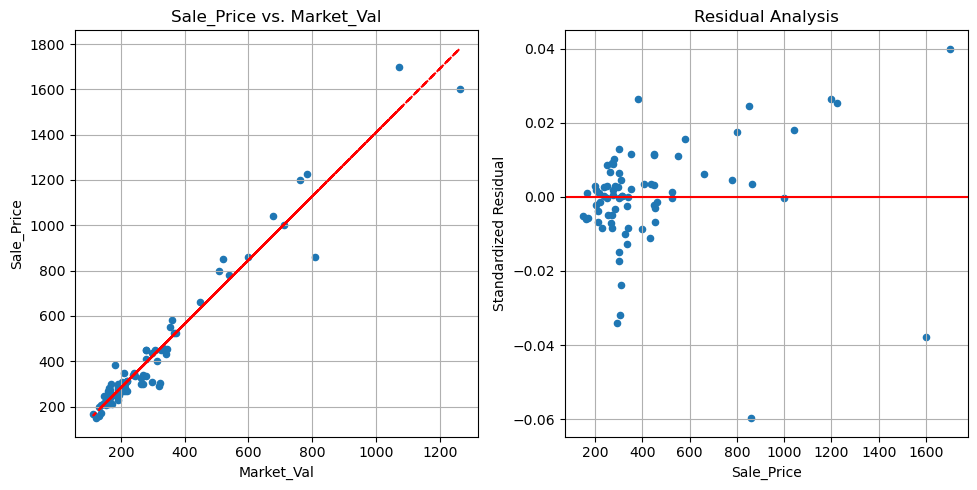

In [6]:
slr = SLR("../linear-regression/dataset/TAMPALMS.csv", "Market_Val", "Sale_Price")
slr.summary()